# Business Understanding

## Business Objective

## Executive Summary

# Data Engineering

## Import Libraries

In [40]:
# import libraries required to load, transform, analyze and plot data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# remove scientific notation and restrictions on df rows/columns display
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('display.max_colwidth', 100)

## Data Dictionary

Data Source: IBM Cognos Telco Customer Churn Dataset

https://www.kaggle.com/yeanzc/telco-customer-churn-ibm-dataset

7043 observations with 33 variables

Column Definitions:

- CustomerID: A unique ID that identifies each customer.
- Count: A value used in reporting/dashboarding to sum up the number of customers in a filtered set.
- Country: The country of the customer’s primary residence.
- State: The state of the customer’s primary residence.
- City: The city of the customer’s primary residence.
- Zip Code: The zip code of the customer’s primary residence.
- Lat Long: The combined latitude and longitude of the customer’s primary residence.
- Latitude: The latitude of the customer’s primary residence.
- Longitude: The longitude of the customer’s primary residence.
- Gender: The customer’s gender: Male, Female
- Senior Citizen: Indicates if the customer is 65 or older: Yes, No
- Partner: Indicate if the customer has a partner: Yes, No
- Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.
- Tenure Months: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.
- Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No
- Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No
- Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.
- Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No
- Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No
- Device Protection: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No
- Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No
- Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.
- Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.
- Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.
- Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No
- Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check
- Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.
- Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.
- Churn Label: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.
- Churn Value: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.
- Churn Score: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.
- CLTV: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.
- Churn Reason: A customer’s specific reason for leaving the company. Directly related to Churn Category.

## Dataframe Basics

### Load File

In [3]:
# load primary source file to df
tc = pd.read_excel('data/Telco_customer_churn.xlsx', sheet_name='Telco_Churn')
tc.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964,-118.273,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059,-118.307,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048,-118.294,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650,820.500,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062,-118.316,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.800,"3,046.050",Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039,-118.266,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.700,"5,036.300",Yes,1,89,5340,Competitor had better devices


In [4]:
# drop columns not required or duplicative
drop_cols = ['Latitude', 'Longitude', 'Churn Label']
tc.drop(drop_cols, axis=1, inplace=True)

In [5]:
# convert column names to lower case without underscore
tc.columns = tc.columns.str.lower().str.replace(' ','_')

### Info

In [6]:
tc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerid         7043 non-null   object 
 1   count              7043 non-null   int64  
 2   country            7043 non-null   object 
 3   state              7043 non-null   object 
 4   city               7043 non-null   object 
 5   zip_code           7043 non-null   int64  
 6   lat_long           7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   object 
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  tenure_months      7043 non-null   int64  
 12  phone_service      7043 non-null   object 
 13  multiple_lines     7043 non-null   object 
 14  internet_service   7043 non-null   object 
 15  online_security    7043 non-null   object 
 16  online_backup      7043 

**Notes on Info**
- Only non-null issue on Churn Reason (26.5% churned)
- Unexpected Data Types: Total Charges (s/b float)
- Will convert indicator columns from text to 0/1

In [7]:
# check for duplicate customers
dups = tc[tc.duplicated(subset=['customerid'])==True]
print(f'{dups.shape[0]} duplicate CustomerIDs found')

0 duplicate CustomerIDs found


### Data Cleaning

In [8]:
# check value counts by column
col_list = ['gender', 'senior_citizen', 'partner', 'dependents', 
            'phone_service', 'multiple_lines', 'internet_service', 
            'online_security', 'online_backup', 'device_protection', 
            'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 
            'paperless_billing', 'payment_method', 'churn_value', 
            'churn_reason', 'country', 'state', 'city', 'zip_code']

for col in col_list:
     print(f'\nValue Counts | column = {col}')
     print(tc[col].value_counts(normalize=True, dropna=False))


Value Counts | column = gender
Male     0.505
Female   0.495
Name: gender, dtype: float64

Value Counts | column = senior_citizen
No    0.838
Yes   0.162
Name: senior_citizen, dtype: float64

Value Counts | column = partner
No    0.517
Yes   0.483
Name: partner, dtype: float64

Value Counts | column = dependents
No    0.769
Yes   0.231
Name: dependents, dtype: float64

Value Counts | column = phone_service
Yes   0.903
No    0.097
Name: phone_service, dtype: float64

Value Counts | column = multiple_lines
No                 0.481
Yes                0.422
No phone service   0.097
Name: multiple_lines, dtype: float64

Value Counts | column = internet_service
Fiber optic   0.440
DSL           0.344
No            0.217
Name: internet_service, dtype: float64

Value Counts | column = online_security
No                    0.497
Yes                   0.287
No internet service   0.217
Name: online_security, dtype: float64

Value Counts | column = online_backup
No                    0.438
Yes   

**Notes on Value Counts**
- Change encoding to 0/1: Senior Citizen, Partner, Dependents, Phone Service, Multiple Lines, Internet Service, Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies, Paperless Billing
- Create Group: Churn Reason (Customer Service, Product/Network, Pricing, Moved, Unknown)
- One-Hot Coding: Gender, Contract, Payment Method, Churn Reason Group
- All customers in California, USA 
- City distribution is wide, < 10% in major cities. Likely rural telecom co. Explore other geographic attributes.
- Data values look clean, no corrupt values or other NaNs to deal with.

## Data Preparation

###  replace_yes_no(X_df)

In [9]:
# replace yes-no variables with 0/1 for modeling
def replace_yes_no(X_df):
    """Transforms an X features dataframe in place using list of 
    categorical columns to replace class values yes/no to boolean 0/1's.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with replaced values
    """

    bool_list = ['senior_citizen', 'partner', 'dependents', 'phone_service', 
                 'multiple_lines', 'internet_service', 'online_security', 
                 'online_backup', 'device_protection', 'tech_support', 
                 'streaming_tv', 'streaming_movies', 'paperless_billing']
    for col in bool_list:
        X_df.replace({col : { 'Yes' : 1, 'No' : 0, 'No phone service' : 0, 
                                 'No internet service' : 0}}, inplace=True)
    return X_df

### group_churn_reason(X_df)

In [10]:
# create churn reason group to simplify
def group_churn_reason(X_df):
    """Creates new column by mapping churn reason to higher level parent on 
    an X features dataframe.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with new column
    """
    
    reason_map = {'Attitude of support person' : 'Cust Service',
                  'Attitude of service provider' : 'Cust Service', 
                  'Service dissatisfaction' : 'Cust Service', 
                  'Lack of self-service on Website' : 'Cust Service', 
                  'Poor expertise of phone support'  : 'Cust Service', 
                  'Poor expertise of online support' : 'Cust Service', 
                  'Competitor offered higher download speeds' : 'Product', 
                  'Competitor offered more data' : 'Product', 
                  'Competitor had better devices' : 'Product', 
                  'Network reliability' : 'Product', 
                  'Product dissatisfaction' : 'Product', 
                  'Limited range of services' : 'Product', 
                  'Competitor made better offer' : 'Pricing', 
                  'Price too high' : 'Pricing', 
                  'Extra data charges' : 'Pricing', 
                  'Long distance charges' : 'Pricing', 
                  'Lack of affordable download/upload speed' : 'Pricing', 
                  'Moved' : 'Moved', 
                  'Deceased' : 'Moved',
                  'Don\'t know' : 'Unknown'
                 }

    X_df['churn_rsn_grp'] = X_df.churn_reason.map(reason_map)
    return X_df

### impute_total_charges(X_df)

In [11]:
# take a look at total_charges
def impute_total_charges(X_df):
    """Imputes column total_charges in cases where column is non-numeric or 
    blank, using tenure_months and monthly_charge to estimate.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with imputed values
    """
    
    # impute total_charges as monthly x num months
    i=0
    for label, row in X_df.iterrows():
        if not isinstance(row['total_charges'], (int, float)): 
            i+=1
            X_df.loc[label, 'total_charges'] = row['tenure_months']*row['monthly_charges']

    X_df['total_charges'] = X_df['total_charges'].astype(float)
    print(f'Imputed {i} rows of non-numeric total_charges')
    return X_df

### ohe_categories(X_df)

In [12]:
# convert categorical columns to one-hot encoding features
def ohe_categories(X_df):
    """Creates one-hot encoded (OHE) features for a list of categorical columns 
    and simplies column names.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with OHE columns
    """
    
    # create list of multi-class variables for one-hot encoding
    categoricals = ['gender', 'internet_service', 'contract', 'payment_method', 
                    'churn_rsn_grp']

    # create one-hot encoded dummy variables for categoricals
    X_df_ohe = pd.get_dummies(X_df[categoricals], drop_first=False, dtype=int)
    X_df_ohe.rename(columns={'gender_Male' : 'gender_male',
                             'gender_Female' : 'gender_female', 
                             'internet_service_0' : 'internet_svc_none' , 
                             'internet_service_DSL' : 'internet_svc_dsl', 
                             'internet_service_Fiber optic' : 'internet_svc_fiber', 
                             'contract_Month-to-month' : 'contract_mtm', 
                             'contract_One year' : 'contract_1yr', 
                             'contract_Two year' : 'contract_2yr', 
                             'payment_method_Bank transfer (automatic)' : 'pmt_meth_bank_trx_auto', 
                             'payment_method_Credit card (automatic)' : 'pmt_meth_cc_auto', 
                             'payment_method_Electronic check' : 'pmt_meth_echeck', 
                             'payment_method_Mailed check' : 'pmt_meth_mail_check', 
                             'churn_rsn_grp_Cust Service' : 'churn_rsn_grp_cust_svc',                             
                             'churn_rsn_grp_Moved' : 'churn_rsn_grp_moved', 
                             'churn_rsn_grp_Pricing' : 'churn_rsn_grp_pricing', 
                             'churn_rsn_grp_Product' : 'churn_rsn_grp_product', 
                             'churn_rsn_grp_Unknown' : 'churn_rsn_grp_unknown'
                            }, inplace = True)
    
    # concatenate OHE with original df, and drop original category columns
    X_df2 = pd.concat([X_df, X_df_ohe], axis=1)
    X_df2.drop(categoricals, axis=1, inplace=True)
    
    return X_df2

### create_metrics(X_df)

In [13]:
# function creates a few calculated metrics as features
def create_metrics(X_df):
    """Creates calculated fields services_cnt and monthly_charge_life_avg as 
    new features on dataframe.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df (pd.DataFrame)): same dataframe with new columns
    """

    # create column for count of customer's total services (max=11)
    svcs_list = ['phone_service', 'multiple_lines', 'online_security', 
                 'online_backup', 'device_protection', 'tech_support', 
                 'streaming_tv', 'streaming_movies', 'paperless_billing', 
                 'internet_svc_dsl', 'internet_svc_fiber']
    X_df['service_cnt'] = X_df[svcs_list].sum(axis=1)

    # create column for lifetime average monthly charge
    X_df['monthly_charge_life_avg'] = np.where(X_df.tenure_months!=0, 
                                         X_df.total_charges/X_df.tenure_months, 
                                         X_df.monthly_charges)
    return X_df

### Train-Test Split

In [14]:
# Create X predictors and y target variable
y = tc['churn_value']
X = tc.drop(columns=['churn_value'], axis=1)

# Split into training and test sets
SEED = 19
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED)

# 'customerid', 'count', 'country', 'state', 'city', 'zip_code', 'lat_long', 
# 'churn_score', 'churn_reason', 'churn_rsn_grp_moved', 'churn_rsn_grp_product',
# 'churn_rsn_grp_pricing', 'churn_rsn_grp_unknown'

### Data Prep Pipeline

In [15]:
# function holds data preparation pipeline for X predictors dataframe
def data_prep_pipe(X_df):
    """Executes data preparation pipeline of steps to clean and transform
    an X features dataframe.

    Parameters:
    X_df (pd.DataFrame)): train or test slice contains predictors

    Returns:
    X_df_tr (pd.DataFrame)): train or test dataframe, transformed
    """
    
    # instantiate custom transformer functions
    get_replace_yes_no = FunctionTransformer(replace_yes_no, validate=False)
    get_group_churn_reason = FunctionTransformer(group_churn_reason, validate=False)
    get_impute_total_charges = FunctionTransformer(impute_total_charges, validate=False)
    get_ohe_categories = FunctionTransformer(ohe_categories, validate=False)
    get_create_metrics = FunctionTransformer(create_metrics, validate=False)

    # instantiate data prep pipeline object and steps
    prep_pipe = Pipeline(memory=None, 
                         steps=[('replace_yes_no', get_replace_yes_no),
                                ('group_churn_reason', get_group_churn_reason),
                                ('impute_total_charges', get_impute_total_charges),
                                ('ohe_categories', get_ohe_categories),
                                ('create_metrics', get_create_metrics)
                                ])
    
    # apply data prep pipeline to df and store/return new df
    X_df_tr = prep_pipe.fit_transform(X_df)
    return X_df_tr

In [16]:
# send both X_train and X_test through data prep steps
X_train = data_prep_pipe(X_train)
X_test = data_prep_pipe(X_test)

Imputed 8 rows of non-numeric total_charges
Imputed 3 rows of non-numeric total_charges


In [17]:
# create export train file for Tableau data profiling and viz
tc2 = pd.concat([X_train, y_train], axis=1)
tc2.to_csv('data/tc_train_transformed_tableau.csv')

### Select Features

In [69]:
# create features prior to drops
X_train['streams'] = X_train[['streaming_movies', 'streaming_tv']].sum(axis=1)
X_train['pmt_meth_auto'] = X_train[['pmt_meth_cc_auto', 'pmt_meth_bank_trx_auto']].sum(axis=1)
X_train['svc_add_ons'] = X_train[['online_security', 'online_backup', 'device_protection', 'tech_support', 'multiple_lines']].sum(axis=1)

In [138]:
# function drops columns not needed for model from dataframe
def drop_features(X_df):
    model_drops = ['customerid', 'count', 'country', 'city', 'state', 'streaming_movies', 'streaming_tv',
                   'zip_code', 'lat_long', 'churn_score', 'cltv', 'senior_citizen', 'phone_service',
                   'churn_reason', 'churn_rsn_grp_cust_svc', 'churn_rsn_grp_moved', 
                   'churn_rsn_grp_pricing', 'churn_rsn_grp_product', 
                   'churn_rsn_grp_unknown', 'service_cnt', 'monthly_charge_life_avg', 
                   'online_security', 'online_backup', 'device_protection', 'tech_support', 'multiple_lines',
                  'total_charges', 'gender_female', 'gender_male' ,'internet_svc_none', 'svc_add_ons',
                  'pmt_meth_mail_check', 'pmt_meth_cc_auto', 'pmt_meth_bank_trx_auto', 'pmt_meth_echeck', 
                   'contract_mtm']
    X_df_tr = X_df.drop(model_drops, axis=1, inplace=False)
    return X_df_tr

In [131]:
X_train2.head()

,partner,dependents,tenure_months,phone_service,paperless_billing,monthly_charges,internet_svc_dsl,internet_svc_fiber,contract_1yr,contract_2yr,streams,pmt_meth_auto
2396,0,0,2,1,1,20.550,0,0,0,0,0,0
6365,0,0,40,1,0,83.850,0,1,0,0,1,1
5898,0,0,26,1,1,56.050,1,0,1,0,0,0
12,0,1,34,1,1,106.350,0,1,0,0,2,0
5065,0,0,11,1,0,76.400,0,1,0,0,0,0


In [139]:
# apply drop columns against X_train and X_test
X_train2 = drop_features(X_train)
# X_test2 = drop_features(X_test)

### Scale Train/Test

In [140]:
# fit scaler to training data and transform both train and test dataframes
scaler = StandardScaler()
X_train2[X_train2.columns] = scaler.fit_transform(X_train2[X_train2.columns])
# X_test2[X_test2.columns] = scaler.transform(X_test2[X_test2.columns])

## Describe

In [21]:
# basic describe stats
X_train.describe()

,count,zip_code,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn_score,cltv,gender_female,gender_male,internet_svc_none,internet_svc_dsl,internet_svc_fiber,contract_mtm,contract_1yr,contract_2yr,pmt_meth_bank_trx_auto,pmt_meth_cc_auto,pmt_meth_echeck,pmt_meth_mail_check,churn_rsn_grp_cust_svc,churn_rsn_grp_moved,churn_rsn_grp_pricing,churn_rsn_grp_product,churn_rsn_grp_unknown,service_cnt,monthly_charge_life_avg
count,"5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000","5,634.000"
mean,1.000,"93,511.038",0.162,0.484,0.227,32.483,0.903,0.422,0.286,0.345,0.345,0.288,0.389,0.392,0.593,64.998,"2,299.988",58.566,"4,400.792",0.494,0.506,0.214,0.343,0.443,0.550,0.210,0.241,0.219,0.217,0.335,0.230,0.075,0.008,0.054,0.106,0.022,4.749,65.020
std,0.000,"1,871.566",0.369,0.500,0.419,24.598,0.296,0.494,0.452,0.475,0.475,0.453,0.488,0.488,0.491,30.132,"2,277.843",21.568,"1,181.463",0.500,0.500,0.410,0.475,0.497,0.498,0.407,0.427,0.414,0.412,0.472,0.421,0.263,0.091,0.225,0.308,0.147,2.485,30.238
min,1.000,"90,001.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18.250,0.000,5.000,"2,003.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,13.775
25%,1.000,"92,091.000",0.000,0.000,0.000,9.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,35.825,404.237,40.000,"3,465.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,36.732
50%,1.000,"93,546.000",0.000,0.000,0.000,29.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,70.400,"1,401.275",61.000,"4,526.500",0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,70.453
75%,1.000,"95,351.000",0.000,1.000,0.000,56.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,90.150,"3,836.113",75.000,"5,380.000",1.000,1.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,7.000,90.625
max,1.000,"96,161.000",1.000,1.000,1.000,72.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,118.750,"8,684.800",100.000,"6,500.000",1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10.000,121.400


**Notes on Describe**
- Demographics: 16% seniors, 48% w/ partner, 23% w/ dependents, 50% male
- Tenure: Mean is 32 months, Median 29 months, Upper 25% 55 months
- Product: Phone 90%, Multi-line 42%, Security 29%, Backup 34%, Protection 34%, Support 29%, Streaming 38%, DSL 34%, Fiber 44%
- Contract: 21% 1yr, 24% 2yr, 55% month-to-month
- Billing: Paperless 59%, CC Auto 22%, echeck 34%, mail 23%, bank transfer 22%
- Monthly Charges: Average \\$65, Median \\$70, Range \\$18-119

## Outliers

# Data Analysis

## Plots

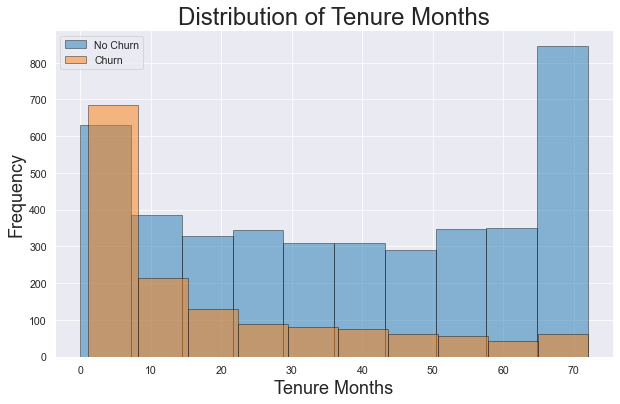

In [22]:
# histogram of the height
tc2[tc2['churn_value'] == 0].tenure_months.plot(kind='hist', color='tab:blue', edgecolor='black', alpha=0.5, figsize=(10,6))
tc2[tc2['churn_value'] == 1].tenure_months.plot(kind='hist', color='tab:orange', edgecolor='black', alpha=0.5, figsize=(10,6))
plt.legend(labels=['No Churn', 'Churn'])
plt.title('Distribution of Tenure Months', size=24)
plt.xlabel('Tenure Months', size=18)
plt.ylabel('Frequency', size=18)
plt.tight_layout
plt.show()

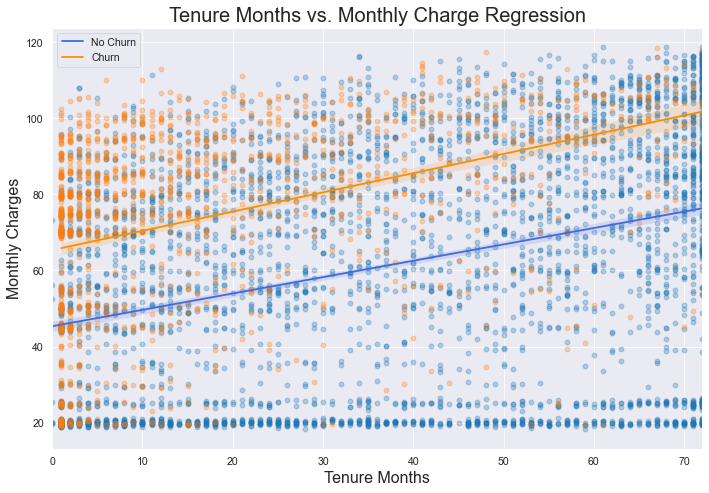

In [23]:
# regression plot using seaborn
tc2_0 = tc2[tc2['churn_value'] == 0]
tc2_1 = tc2[tc2['churn_value'] == 1]

fig = plt.figure(figsize=(10, 7))
sns.regplot(data=tc2_0, x='tenure_months', y='monthly_charges', scatter_kws = {'color': 'tab:blue', 'alpha' : 0.3}, line_kws={'color' : 'royalblue'}) 
sns.regplot(data=tc2_1, x='tenure_months', y='monthly_charges', scatter_kws = {'color': 'tab:orange', 'alpha' : 0.3}, line_kws={'color' : 'darkorange'})

# Legend, title and labels.
plt.legend(labels=['No Churn', 'Churn'])
plt.title('Tenure Months vs. Monthly Charge Regression', size=20)
plt.xlabel('Tenure Months', size=16)
plt.ylabel('Monthly Charges', size=16)
plt.tight_layout()
plt.show()

## Correlation

In [24]:
# create column correlation matrix
corr = tc2.corr()

# limit to churn target and drop non-predictive fields
corr_churn = corr.copy().loc[:, 'churn_value'].sort_values(ascending=False)
to_drop = ['zip_code', 'count', 'churn_value', 'churn_score', 'churn_rsn_grp_product', 
           'churn_rsn_grp_cust_svc', 'churn_rsn_grp_pricing', 'churn_rsn_grp_moved', 
           'churn_rsn_grp_unknown']
corr_churn = corr_churn.drop(to_drop)
corr_churn

contract_mtm               0.402
pmt_meth_echeck            0.303
internet_svc_fiber         0.302
monthly_charges            0.193
monthly_charge_life_avg    0.192
paperless_billing          0.189
senior_citizen             0.136
streaming_movies           0.074
streaming_tv               0.062
multiple_lines             0.049
service_cnt                0.024
phone_service              0.011
gender_female              0.010
gender_male               -0.010
device_protection         -0.062
online_backup             -0.078
pmt_meth_mail_check       -0.096
pmt_meth_bank_trx_auto    -0.113
internet_svc_dsl          -0.119
cltv                      -0.132
pmt_meth_cc_auto          -0.135
partner                   -0.140
tech_support              -0.170
online_security           -0.170
contract_1yr              -0.178
total_charges             -0.192
internet_svc_none         -0.228
dependents                -0.247
contract_2yr              -0.299
tenure_months             -0.344
Name: chur

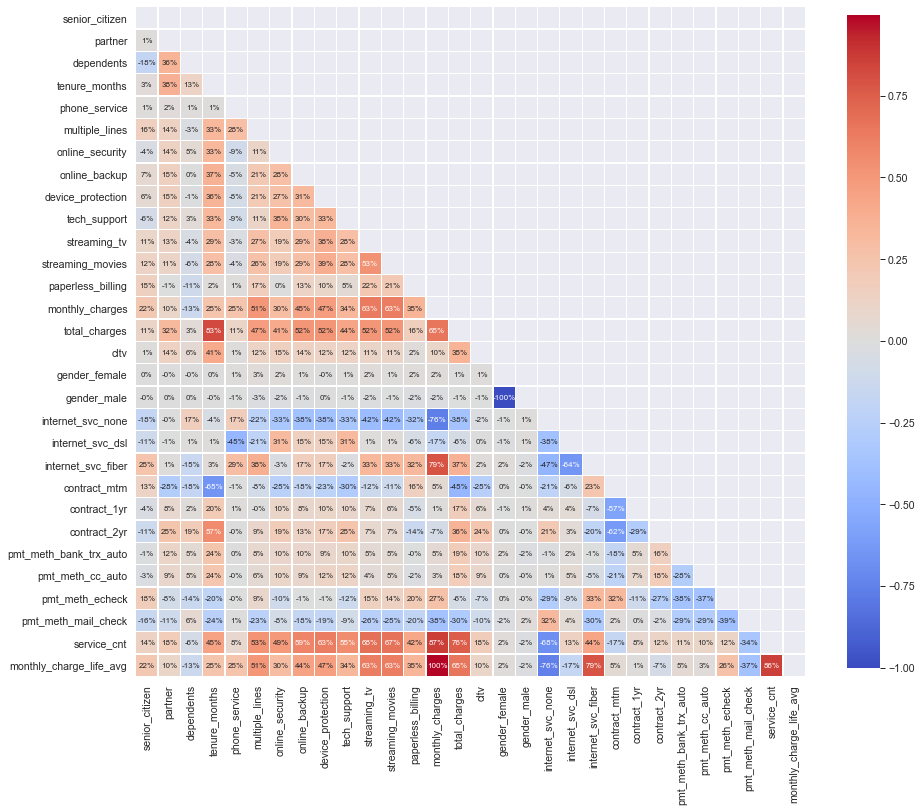

In [25]:
# show heatmap for correlation matrix
f, ax = plt.subplots(figsize=(15,15))
corr2 = corr.drop(to_drop).drop(to_drop, axis=1)
mask = np.zeros(corr2.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(corr2, mask = mask, fmt='.0%',
            center=0, linewidths=0.3, cmap='coolwarm', square=True, 
            annot=True, cbar_kws={'shrink': 0.8}, annot_kws={'size': 8})
plt.tight_layout
plt.show()

In [26]:
# check for collinearity among potential predictors by pairs
df = (
     corr2
     .stack()
     .reset_index()
     .sort_values(0, ascending=False)
)
# zip the default name columns level_0 and level_1
df['pairs'] = list(zip(df.level_0, df.level_1))
# set index to pairs
df.set_index(['pairs'], inplace=True)
# now drop level columns
df.drop(columns=['level_1', 'level_0'], inplace=True)
# rename correlation column rather than 0
df.columns = ['correlation']
# drop duplicates and keep only pair correlations above 0.65
df.drop_duplicates(inplace=True)
df[abs(df.correlation) > .65]

,correlation
pairs,
"(senior_citizen, senior_citizen)",1.000
"(monthly_charges, monthly_charge_life_avg)",0.996
"(monthly_charges, service_cnt)",0.865
"(service_cnt, monthly_charge_life_avg)",0.862
"(total_charges, tenure_months)",0.827
"(monthly_charges, internet_svc_fiber)",0.789
"(monthly_charge_life_avg, internet_svc_fiber)",0.786
"(total_charges, service_cnt)",0.757
"(service_cnt, streaming_tv)",0.677


## Models

# Churn Models

### display_confusion

In [27]:
# plot confusion matrix for DT classifier
def display_confusion(model, X, y_true, labels=None):
    plot_confusion_matrix(model, X, y_true, cmap=plt.cm.Blues, 
                          display_labels=labels)
    plt.grid(False)     
    plt.tight_layout()
    plt.show()

### m0 Dummy Classifier

In [28]:

dum = DummyClassifier(strategy="stratified")
dum.fit(X_train, y_train)
y_hat_train_m0 = dum.predict(X_train_m0)


NameError: name 'X_train_m0' is not defined

### m1 Decision Tree Vanilla

In [ ]:
# select feautres to feed dt model
m1_drops = ['customerid', 'count', 'country', 'city', 'state', 'zip_code', 
            'lat_long', 'churn_score', 'cltv', 'churn_reason', 
            'churn_rsn_grp_cust_svc', 'churn_rsn_grp_moved', 
            'churn_rsn_grp_pricing', 'churn_rsn_grp_product', 
            'churn_rsn_grp_unknown']
X_train_tr_m1 = X_train_tr.copy().drop(m1_drops, axis=1, inplace=False)
X_test_tr_m1 = X_test_tr.copy().drop(m1_drops, axis=1, inplace=False)
X_train_tr_m1.head()

In [ ]:
# train a DT classifier using training data 
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=SEED, max_depth=3)
dt.fit(X_train_tr_m1, y_train)

In [ ]:
# make predictions using test set 
y_test_pred_m1 = dt.predict(X_test_tr_m1)

In [ ]:
y_train_pred_m1 = dt.predict(X_train_tr_m1)

In [ ]:
score_model(y_train, y_train_pred_m1)

In [ ]:
score_model(y_test, y_test_pred_m1)

In [ ]:
# plot confusion matrix for DT classifier
plot_confusion_matrix(dt, X_train_tr_m1, y_train, cmap=plt.cm.Blues, 
                      display_labels=['No Churn', 'Churn'])
plt.grid(False)     
plt.tight_layout()
plt.show()
# change paper color in plt

In [ ]:
plot_confusion_matrix(dt, X_test_tr_m1, y_test, cmap=plt.cm.Blues )
#                       display_labels=['No Churn', 'Churn'])
plt.grid(False)     
plt.tight_layout()
plt.show()

In [ ]:
# Plot and show decision tree
plt.figure(figsize=(12,12), dpi=500)
tree.plot_tree(dt, 
               feature_names=X_train_tr_m1.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.tight_layout()
plt.show()

### m2 Logistic Regression

#### Instantiate Models

In [29]:
# now let us contruct some pipelines of our choice.
jobs = 4
    
model_lr = LogisticRegression(random_state=SEED, fit_intercept=False, max_iter=500, n_jobs=jobs)
# model_lr.get_params().keys()

#### Set Grid Params

In [30]:
# Define the grid
c_params = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

grid_params_lr = [{'C' : c_params, 'solver' : ['liblinear', 'saga'], 
                   'penalty': ['l1', 'l2'], 
                   'class_weight' : [None, 'balanced', 
                                         {1:2, 0:1}, {1:3, 0:1}, {1:5, 0:1}]}]

# grid_params_rf = 

In [31]:
# set common scoring metrics for use across models
scoring = { 'roc_auc' : make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=False),
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score),
            'recall': make_scorer(recall_score),
            'f1': make_scorer(f1_score)}

#### GridSearch CVs

In [32]:
# 
gs_lr = GridSearchCV(estimator=model_lr, param_grid=grid_params_lr, 
                  scoring=scoring, refit='roc_auc', 
                  cv=StratifiedKFold(n_splits=5, random_state=SEED, 
                                     shuffle=True))

In [ ]:
# List of pipelines for iterating through each of them
grids = [gs_lr]

# Creating a dict for our reference
grid_dict = {0: 'Logistic Regression', 
        1: 'Random Forest',
        2: 'Support Vector Machine'}

#### Run GridSearch

In [141]:
# Fit the training data
gs_lr.fit(X_train2, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=LogisticRegression(fit_intercept=False, max_iter=500,
                                          n_jobs=4, random_state=19),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'class_weight': [None, 'balanced', {0: 1, 1: 2},
                                           {0: 1, 1: 3}, {0: 1, 1: 5}],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']}],
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

#### CV Results Metrics

In [142]:
# capture gridsearch results into dataframe
cv_results = pd.DataFrame.from_dict(gs_lr.cv_results_)

# key metrics to evaluate model performance
metrics = ['params', 'mean_test_roc_auc', 'mean_test_accuracy', 
           'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 
           'rank_test_roc_auc', 'rank_test_recall']

cv_results_metrics = cv_results.loc[:, metrics]
cv_results_metrics.sort_values(by=['rank_test_roc_auc'], inplace=True)

cv_results_metrics[:20]

,params,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,rank_test_roc_auc,rank_test_recall
61,"{'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}",0.757,0.695,0.462,0.889,0.608,1,105
60,"{'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}",0.757,0.695,0.461,0.889,0.607,2,105
62,"{'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}",0.757,0.695,0.462,0.888,0.607,3,121
63,"{'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}",0.757,0.695,0.462,0.888,0.607,3,121
121,"{'C': 1000, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}",0.757,0.695,0.461,0.889,0.607,5,105
80,"{'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}",0.757,0.695,0.461,0.889,0.607,5,105
82,"{'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}",0.757,0.695,0.461,0.889,0.607,5,105
83,"{'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}",0.757,0.695,0.461,0.889,0.607,5,105
123,"{'C': 1000, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}",0.757,0.695,0.461,0.889,0.607,5,105
100,"{'C': 100, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}",0.757,0.695,0.461,0.889,0.607,5,105


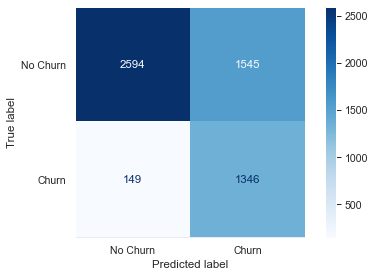

In [113]:
# print confusion matrix for best model
best_model_lr = gs_lr.best_estimator_
display_confusion(best_model_lr, X_train2, y_train, labels=['No Churn', 'Churn'])

In [135]:
coef_table = pd.DataFrame(X_train2.columns, columns=['feature'])
coef_table.insert(1, "coef", best_model_lr.coef_.transpose())
coef_table

ValueError: Length of values (18) does not match length of index (12)

In [136]:

fig = plt.figure(figsize=(18, 8))
sns.barplot(x='feature', y='coef', data=coef_table, palette='vlag')

# Legend, title and labels.
plt.title('Model Coefficients by Feature', size=20)
plt.xlabel('Feature', size=16)
plt.ylabel('Model Coefficient', size=16)
plt.xticks(rotation=-80)
plt.tight_layout()
plt.show()

ValueError: Could not interpret input 'coef'

<Figure size 1296x576 with 0 Axes>

In [81]:
# Print the accuracy on test set
gs_lr.score(X_test2, y_test)

ValueError: X has 9 features per sample; expecting 12

#### Statsmodel Logit

In [143]:
# Fit the training data
sm_lr = sm.Logit(y_train, sm.add_constant(X_train2)).fit()
print(sm_lr.summary())

Optimization terminated successfully.
         Current function value: 0.407370
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            churn_value   No. Observations:                 5634
Model:                          Logit   Df Residuals:                     5622
Method:                           MLE   Df Model:                           11
Date:                Thu, 15 Apr 2021   Pseudo R-squ.:                  0.2959
Time:                        17:43:07   Log-Likelihood:                -2295.1
converged:                       True   LL-Null:                       -3259.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.7290      0.055    -31.551      0.000      -1.836      -1.622
partn

### m3 Random Forest

In [ ]:
model_rf = RandomForestClassifier(random_state=SEED, fit_intercept=False, max_iter=500, n_jobs=jobs) 